In [1]:
from gcsa.event import Event
from gcsa.google_calendar import GoogleCalendar
from gcsa.recurrence import Recurrence, DAILY, SU, SA

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd

from datetime import datetime, timedelta, date, time
import dateutil
from dateutil.parser import parse
import calendar
import numpy as np
from circle_cal.model import CalendarElement
import circle_cal as cc
import circle_cal.model as model
import circle_cal.plot as ccplot
import pathlib
from rich import print
import pytz
from pytz import timezone

In [2]:
ETZ = timezone("America/New_York")
def localize_any(obj, tz):
    try:
        return tz.localize(obj)
    except ValueError:
        if obj.tzinfo:
            return obj
    except AttributeError:
        return tz.localize(datetime.combine(obj, time(0,0)))
    return obj

def year_to_sunburst(year):
    y = CalendarElement(year=year)
    parents = [None]
    names = [y.year.value]
    values = [1]
    for m in y:
        parents.append(y.year.value)
        names.append(m.name)
        values.append(1)
        for day in m:
            parents.append(m.name)
            names.append(f"{day.year}-{day.month}-{day.day}")
            values.append(1)
    return dict(parents=parents,
                labels=names, values=values)
yd = year_to_sunburst(2024)

In [3]:
cred = pathlib.Path('/Users/kdavis10/.config/.credentials')
cred_json = "pygooglecal.apps.googleusercontent.com.json"

try:
    gcal = GoogleCalendar(credentials_path=cred / cred_json)
except Exception as e:
    (cred / "token.pickle").unlink()

In [19]:
year = y24 = CalendarElement(year=2024)

traces = []

clist = list(gcal.get_calendar_list())
sel_cal_summ = ["http://universerevealed.nd.edu/?eme_ical=public",
                "NYT Astronomy and Space Calendar",
                "kdavis10@nd.edu",
                "ND-DVT Calendar",
                "CoS College-wide Events & Conferences",
                "Keith Davis",
                "Axis Ludi Calendar",
                "Holidays in United States",
                "Academic Calendar",
                "Seasons"]

selcal = [c for c in clist if c.summary in sel_cal_summ]
print(selcal)

def weekday(datelike):
    return list(calendar.day_name)[calendar.weekday(datelike.year, datelike.month, datelike.day)]

def is_weekend(datelike):
    if calendar.weekday(datelike.year, datelike.month, datelike.day) in [5, 6]:
        return True
    else:
        return False

def weekends(year):
    ws = []
    start = None
    for d in CalendarElement(year=2024).recursive_iteration("day"):
        d = d.datetime()
        if is_weekend(d):
            if start is None:
                start=d
            else:
                ws.append(model.Event(start, end=d))
                start=None
    return ws

ws = weekends(2024)

[
    <CalendarListEntry None - (http://universerevealed.nd.edu/?eme_ical=public)>,
    <CalendarListEntry None - (NYT Astronomy and Space Calendar)>,
    <CalendarListEntry None - (kdavis10@nd.edu)>,
    <CalendarListEntry None - (ND-DVT Calendar)>,
    <CalendarListEntry None - (CoS College-wide Events & Conferences)>,
    <CalendarListEntry None - (Keith Davis)>,
    <CalendarListEntry None - (Axis Ludi Calendar)>,
    <CalendarListEntry ND Academic Calendar - (Academic Calendar)>,
    <CalendarListEntry None - (Holidays in United States)>,
    <CalendarListEntry None - (Seasons)>
]

In [20]:


dfs = []
for cal in selcal:
    events = gcal.get_events(y24.start.datetime(),
                             y24.stop.datetime(),
                             single_events=True,
                             calendar_id=cal.calendar_id,
                            )

    df = pd.DataFrame(data=[model.EventWrap(ev) for ev in events if ev.other["eventType"] != "workingLocation"],
                      columns=["Event_obj"]
                     )
    
    df["color"] = cal.background_color
    df["calendar_id"] = cal.calendar_id
    df["calendar"] = cal.summary
    dfs.append(df)
    
df = pd.concat(dfs, axis="rows", ignore_index=True)
df["duration"] = df["Event_obj"].apply(lambda ev: ev.duration)
df["mid"] = pd.to_datetime(df["Event_obj"].apply(lambda ev: localize_any(ev.mid, ETZ)), utc=True).dt.tz_convert(ETZ)
df["start"] = pd.to_datetime(df["Event_obj"].apply(lambda ev: localize_any(ev.start, ETZ)), utc=True).dt.tz_convert(ETZ)
df["end"] = pd.to_datetime(df["Event_obj"].apply(lambda ev: localize_any(ev.end, ETZ)), utc=True).dt.tz_convert(ETZ)
#df["end"] = df["Event_obj"].apply(lambda ev: ev.end)


df["summary"] = df["Event_obj"].apply(lambda ev: ev.summary)
df["weekday"] = df.start.apply(weekday)


In [21]:
df24 = df[df["start"] >= pd.Timestamp("2024-01-01", tzinfo=ETZ)]
df24 = df24[df24["start"] <= pd.Timestamp("2025-01-01", tzinfo=ETZ)]

In [22]:
ii = pd.IntervalIndex([pd.Interval(pd.Timedelta(days=0), pd.Timedelta(hours=23, minutes=59, seconds=59)),
                       pd.Interval(pd.Timedelta(hours=23, minutes=59, seconds=59), pd.Timedelta(days=1)),
                       pd.Interval(pd.Timedelta(days=1), pd.Timedelta(days=31)),
                       pd.Interval(pd.Timedelta(days=31), pd.Timedelta(days=365))])
intervalsdf = pd.DataFrame(data=["hours", "day", "weeks", "months"], index=ii, columns=["name"])
intervalsdf["opacity"] = [1, 0.8, 0.7, 0.5]
intervalsdf["rbase"] = list(reversed([0.5, 0.6, 0.7, 0.8]))
intervalsdf

,name,opacity,rbase
"(0 days 00:00:00, 0 days 23:59:59]",hours,1.0,0.8
"(0 days 23:59:59, 1 days 00:00:00]",day,0.8,0.7
"(1 days 00:00:00, 31 days 00:00:00]",weeks,0.7,0.6
"(31 days 00:00:00, 365 days 00:00:00]",months,0.5,0.5


In [23]:
df["scale"] = pd.cut(df["duration"], intervalsdf.index)

In [24]:
df["ring"] = intervalsdf["name"].loc[df["scale"]].reset_index(drop=True)
df["opacity"] = intervalsdf["opacity"].loc[df["scale"]].reset_index(drop=True)
df["rbase"] = intervalsdf["rbase"].loc[df["scale"]].reset_index(drop=True)

In [25]:
def ts_to_theta(ts, t0=0, day_to_theta=365/360):
    return (timedelta(seconds=(ts - t0)) / timedelta(days=1)) / day_to_theta

def calendar_ticks(year):
    tickvals = []
    ticktext = []
    for m in year:
        tickvals.append(ts_to_theta(model.to_timestamp(m.start.datetime()),
                                    model.to_timestamp(year.start.datetime()),
                                    (year.duration / timedelta(days=1)) / 360))
        #tickvals.append(ts_to_theta(model.to_timestamp(m.mid),
         #                           model.to_timestamp(year.start.datetime()),
          #                          (year.duration / timedelta(days=1)) / 360))
        #ticktext.append("")
        ticktext.append(m.name)
    return (tickvals, ticktext)
        

##def ring_to_base(ring, intervalsdf):
 #   dr = 1/(len(intervalsdf) + 1)
 #   rvalues = [(r+1) * dr for r in range(len(intervalsdf))]   
 #   d = dict(zip(intervalsdf.name.values, reversed(rvalues)))
 #   return d[ring]
    
year=y24

df["midtheta"] = df.mid.apply(lambda x: ts_to_theta(model.to_timestamp(x),
                                                    model.to_timestamp(y24.start.datetime()),
                                                    year.duration / timedelta(days=1) / 360))
df["width"] = df.duration.apply(lambda x: x / year.duration * 360)
#df["rbase"] = df.ring.apply(lambda x: ring_to_base(x, intervalsdf))
#df["rbase"] = .5
df["r"] = .1 * .97 #1/(len(intervalsdf) + 1) * .97


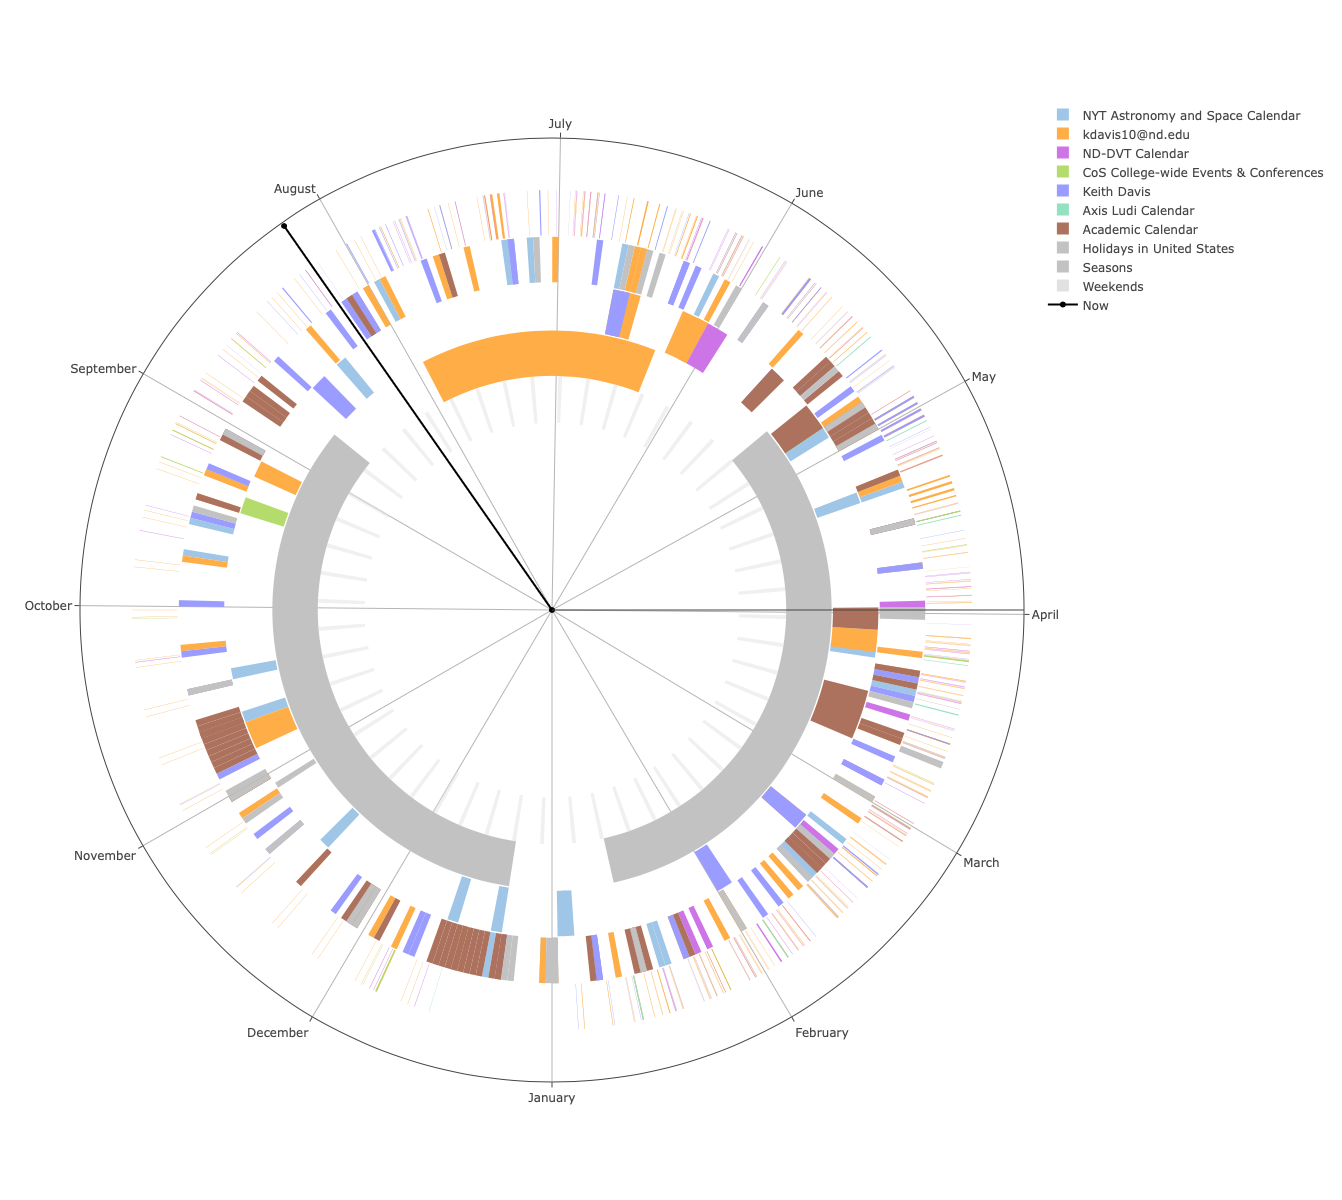

In [38]:
dring = df
try:
    del f
except NameError:
    pass
f = go.Figure()

for cal in pd.unique(df.calendar):
    df = dring[dring["calendar"] == cal]
    f.add_trace(go.Barpolar(theta=df.midtheta, r=df.r, width=df.width, base=df.rbase,
                            text=df.summary, marker_color=df.color, name=cal, #marker_opacity=df.opacity
                            customdata=df[["start", "end"]]
                           )
               )
df = dring
tickvals, ticktext = calendar_ticks(y24)

f.add_trace(go.Barpolar(theta=[ts_to_theta(model.to_timestamp(w.mid), model.to_timestamp(y24.start.datetime())) for w in ws],
                        #r=len(ws) * [.167], base=.167,
                        r=len(ws) * [.1], base=.4,
                        marker_color="#E1E1E1", marker_opacity=.5,
                        width=[(w.duration / year.duration * 360) for w in ws], name="Weekends",
                       customdata=[(w.start, w.end) for w in ws])
           )

f.update_layout(height=1200)
f.update_layout(
    template=None,
    polar = dict(
        radialaxis = dict(tickvals=[intervalsdf.rbase],
                          showticklabels=False, ticks='',
                         ),
        angularaxis = dict(
            rotation = -90,
            showticklabels=True,
            ticks='outside',
            ticktext=ticktext,
            tickvals=tickvals,
        )
    )
)
f.update_traces(hovertemplate="%{text}<br>Start: %{customdata[0]|%Y/%m/%d %H:%M:%S.%L}"
               "<br>End: %{customdata[1]|%Y/%m/%d %H:%M:%S.%L}")
#f.add_trace(go.Sunburst(yd))
f.add_trace(go.Scatterpolar(r=[0, 1], theta=2*[ts_to_theta(model.to_timestamp(datetime.now()),
                                                           model.to_timestamp(y24.start.datetime()),
                                                          366 / 360)], name="Now", marker_color="black", text=["Today"]*2))
f.show()

In [37]:
f.layout

Layout({
    'height': 1200,
    'polar': {'angularaxis': {'rotation': -90,
                              'showticklabels': True,
                              'ticks': 'outside',
                              'ticktext': [January, February, March, April, May,
                                           June, July, August, September, October,
                                           November, December],
                              'tickvals': [0.0, 30.491803278688526,
                                           59.016393442622956, 89.4672131147541,
                                           118.97540983606558, 149.46721311475412,
                                           178.97540983606558, 209.46721311475412,
                                           239.95901639344265, 269.4672131147541,
                                           299.9590163934426, 329.5081967213115]},
              'radialaxis': {'showticklabels': False, 'ticks': '', 'tickvals': [[0.8, 0.7, 0.6, 0.5]]}},
    'te

In [ ]:
df[df["calendar"] == "Academic Calendar"]

In [ ]:
f.data[0]["customdata"][:,0]

In [13]:
dring

,Event_obj,color,calendar_id,calendar,duration,mid,start,end,summary,weekday,scale,ring,opacity,rbase,midtheta,width,r
0,<circle_cal.model.EventWrap object at 0x1076e6...,#9fc6e7,nytimes.com_89ai4ijpb733gt28rg21d2c2ek@group.c...,NYT Astronomy and Space Calendar,1 days 00:00:00,2024-01-01 12:00:00-05:00,2023-12-31 23:56:00-05:00,2024-01-01 23:56:00-05:00,Happy New Year From Science Times,Sunday,"(0 days 23:59:59, 1 days 00:00:00]",day,0.8,0.8,0.491803,0.983607,0.097
1,<circle_cal.model.EventWrap object at 0x105e86...,#9fc6e7,nytimes.com_89ai4ijpb733gt28rg21d2c2ek@group.c...,NYT Astronomy and Space Calendar,2 days 00:00:00,2024-01-04 00:00:00-05:00,2024-01-02 23:56:00-05:00,2024-01-04 23:56:00-05:00,The Quadrantid meteor shower will reach its peak.,Tuesday,"(1 days 00:00:00, 31 days 00:00:00]",weeks,0.7,0.7,2.950820,1.967213,0.097
2,<circle_cal.model.EventWrap object at 0x107571...,#9fc6e7,nytimes.com_89ai4ijpb733gt28rg21d2c2ek@group.c...,NYT Astronomy and Space Calendar,2 days 00:00:00,2024-04-22 00:00:00-04:00,2024-04-21 00:56:00-04:00,2024-04-23 00:56:00-04:00,The Lyrid meteor shower will reach its peak.,Sunday,"(1 days 00:00:00, 31 days 00:00:00]",weeks,0.7,0.7,110.122951,1.967213,0.097
3,<circle_cal.model.EventWrap object at 0x1084bd...,#9fc6e7,nytimes.com_89ai4ijpb733gt28rg21d2c2ek@group.c...,NYT Astronomy and Space Calendar,2 days 00:00:00,2024-08-12 00:00:00-04:00,2024-08-11 00:56:00-04:00,2024-08-13 00:56:00-04:00,The Perseid meteor shower will reach its peak.,Sunday,"(1 days 00:00:00, 31 days 00:00:00]",weeks,0.7,0.7,220.286885,1.967213,0.097
4,<circle_cal.model.EventWrap object at 0x1084be...,#9fc6e7,nytimes.com_89ai4ijpb733gt28rg21d2c2ek@group.c...,NYT Astronomy and Space Calendar,1 days 00:00:00,2024-09-22 12:00:00-04:00,2024-09-22 00:56:00-04:00,2024-09-23 00:56:00-04:00,Autumn is here.,Sunday,"(0 days 23:59:59, 1 days 00:00:00]",day,0.8,0.8,261.106557,0.983607,0.097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,<circle_cal.model.EventWrap object at 0x1088d3...,#c2c2c2,en.usa#holiday@group.v.calendar.google.com,Holidays in United States,1 days 01:00:00,2024-11-03 12:30:00-05:00,2024-11-03 00:56:00-04:00,2024-11-03 23:56:00-05:00,Daylight Saving Time ends,Sunday,"(1 days 00:00:00, 31 days 00:00:00]",weeks,0.7,0.7,302.479508,1.024590,0.097
765,<circle_cal.model.EventWrap object at 0x1088d3...,#c2c2c2,en.usa#holiday@group.v.calendar.google.com,Holidays in United States,1 days 00:00:00,2024-01-01 12:00:00-05:00,2023-12-31 23:56:00-05:00,2024-01-01 23:56:00-05:00,New Year's Day,Sunday,"(0 days 23:59:59, 1 days 00:00:00]",day,0.8,0.8,0.491803,0.983607,0.097
766,<circle_cal.model.EventWrap object at 0x1088d3...,#c2c2c2,en.usa#holiday@group.v.calendar.google.com,Holidays in United States,1 days 00:00:00,2024-01-15 12:00:00-05:00,2024-01-14 23:56:00-05:00,2024-01-15 23:56:00-05:00,Martin Luther King Jr. Day,Sunday,"(0 days 23:59:59, 1 days 00:00:00]",day,0.8,0.8,14.262295,0.983607,0.097
767,<circle_cal.model.EventWrap object at 0x1088d3...,#c2c2c2,en.usa#holiday@group.v.calendar.google.com,Holidays in United States,1 days 00:00:00,2024-02-14 12:00:00-05:00,2024-02-13 23:56:00-05:00,2024-02-14 23:56:00-05:00,Valentine's Day,Tuesday,"(0 days 23:59:59, 1 days 00:00:00]",day,0.8,0.8,43.770492,0.983607,0.097


In [47]:
list(events)

[]

In [51]:
    events = gcal.get_events(y24.start.datetime(),
                             y24.stop.datetime(),
                             single_events=True,
                             calendar_id=selcal[1],
                            )

In [56]:
eve = next(gcal.get_events())

In [57]:
wr = model.EventWrap(eve)

In [62]:
localize_any(wr.start, ETZ)

datetime.datetime(2017, 5, 1, 0, 0, tzinfo=<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>)

In [64]:
datetime.combine(wr.start, time(0,0))

datetime.datetime(2017, 5, 1, 0, 0)

In [65]:
ETZ

<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>